In [24]:
import numpy as np
from torch import nn
import torch
import matplotlib.pyplot as plt
import gymnasium as gym
from torch.optim import Adam
from torch.nn import MSELoss, HuberLoss
from torch.nn import init
from gymnasium.wrappers import RecordVideo
from Exploration.EpsilonGreedyExploration import (
    epsilon_decay,
    epsilon_greedy,
    linear_epsilon_decay,
)
from Buffers.ExperienceReplayBuffer import ExperienceReplay
import os
# from Buffers.ExperienceReplayBuffer import ExperienceReplay

In [25]:
ls = [(1, 2), (4, 3)]
a, b = map(tuple, zip(*ls))
list(zip(*ls))

[(1, 4), (2, 3)]

In [27]:
PROJECT_NAME = "N_StepDQN"
ENV_NAME ="CartPole-v1"
SEED = 13 
LEARNING_RATE = 1e-3
BUFFER_SIZE =20000
GAMMA = 0.99
EPISODES= 701
STEPS=1000
BATCH_SIZE = 64
EPSILON=1.0
N_STEP =5

<center><b>Test and Explore Environment


action_num = 2 | state num = 4


c:\Users\pooya\miniconda3\envs\AI\lib\site-packages\gymnasium\wrappers\rendering.py:283: UserWarning: WARN: Overwriting existing videos at c:\Users\pooya\Projects\Programming\Artificial intelligence\Reinforcement Learning\Reinforement Learning\ValueBased\videos\N_StepDQN\CartPole-v1 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


(-0.5, 599.5, 399.5, -0.5)

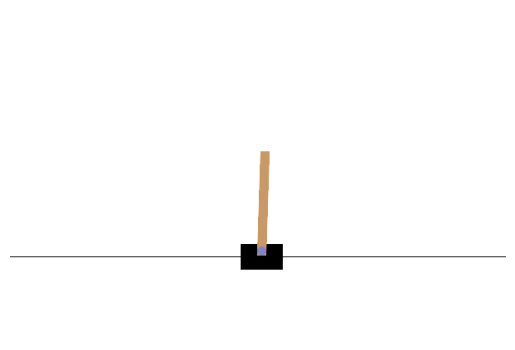

In [28]:
import random
random.seed(13)

env = gym.make(ENV_NAME, render_mode="rgb_array")
video_directory = f'./videos/{PROJECT_NAME}/{ENV_NAME}'
env = RecordVideo(
    env,
    video_directory,
    episode_trigger=lambda episode_id: episode_id % 25 == 0,
    fps=15,
)
env.reset(seed=SEED)
state_num = env.observation_space.shape[0]
action_num = env.action_space.n
print(f"action_num = {action_num} | state num = {state_num}")
plt.imshow(env.render())
plt.axis("off")

In [29]:
class QNetfork(nn.Module):
    def __init__(self, input_num, h1, h2, h3, output_num):
        super().__init__()
        self.linear1 = nn.Linear(input_num, h1)
        self.linear2 = nn.Linear(h1, h2)
        self.linear3 = nn.Linear(h2, h3)
        self.linear4 = nn.Linear(h3, output_num)

        self.init_weight()

    def init_weight(self):
        for module in self.modules():
            if isinstance(module, nn.Linear):
                init.kaiming_normal_(module.weight, nonlinearity="relu")
                if module.bias is not None:
                    init.constant_(module.bias, 0)

    def forward(self, x):
        x = torch.relu(self.linear1(x))
        x = torch.relu(self.linear2(x))
        x = torch.relu(self.linear3(x))
        x = self.linear4(x)
        return x

In [30]:
a = [1,2,3,4,5,6,7,8,9]
a[:-3]

[1, 2, 3, 4, 5, 6]

In [31]:
class N_STEP_ExperienceReplay():
    
    def __init__(self,max_value,device="cpu",n_step = 1):
        self.experience_replay = deque(maxlen=max_value)
        self.max_value         = max_value
        self.device            = device
        self.n_step            = n_step
        random.seed(13)
    def append(self,old_state,old_action,reward,new_state,done):
        experience               = {}
        experience["old_state"]  = old_state
        experience["old_action"] = old_action
        experience["reward"]     = reward
        experience["new_state"]  = new_state
        experience["done"]       = done
        self.experience_replay.append(experience)
        
    def sample(self,batch_size):
        # print("size" + str(self.size()))
        # print("size" + str(list(enumerate(list(self.experience_replay)[:-self.n_step])).__len__()))
        
        batch      = random.sample(list(enumerate(list(self.experience_replay)[:-self.n_step])),batch_size)
        idx,batch  = map(list,zip(*batch))
        old_state  = torch.tensor(np.array([x["old_state"]for x in batch]),device=self.device)
        old_action = torch.tensor(np.array([x["old_action"]for x in batch]),device=self.device)
        n_step_rewards = []
        reward = []
        new_state = []
        done = []
        for i in idx:
            n_step_rewards.clear()
            for n in range(self.n_step-1):
                # print(f"index={i}")
                n_step_rewards.append(self.experience_replay[i+n]["reward"])
            reward.append(n_step_rewards)
            new_state.append( self.experience_replay[i+self.n_step-1]["new_state"])
            done.append(self.experience_replay[i+self.n_step-1]["done"])
        reward    = torch.tensor(np.array(reward),device=self.device)
        # print(reward.shape)        
        new_state = torch.tensor(np.array(new_state),device=self.device)
        done      = torch.tensor(np.array(done),device=self.device)
        return (old_state,old_action,reward,new_state,done)
    def size(self):
        return len(self.experience_replay)
    def __len__(self):
        return self.size()

In [ ]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
from torchsummary import summary

torch.manual_seed(SEED)
model        = QNetfork(state_num, 256, 128, 64, action_num).to((device))
target_model = QNetfork(state_num, 256, 128, 64, action_num).to((device))
target_model.load_state_dict(model.state_dict())
criterion    = MSELoss()
optimizer    = Adam(model.parameters(), lr=LEARNING_RATE)
buffer       = N_STEP_ExperienceReplay(BUFFER_SIZE, device, N_STEP)
summary(model, (state_num,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 256]           1,280
            Linear-2                  [-1, 128]          32,896
            Linear-3                   [-1, 64]           8,256
            Linear-4                    [-1, 2]             130
Total params: 42,562
Trainable params: 42,562
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.16
Estimated Total Size (MB): 0.17
----------------------------------------------------------------


In [ ]:
only_exploit = False
rewards = []
total_steps = 0
for episode in range(EPISODES):

    total_reward = 0
    old_observation, _ = env.reset(seed=SEED)

    if episode % 50 == 0:
        only_exploit = True
    else:
        only_exploit = False

    for step in range(STEPS):
        obs = torch.tensor(old_observation).float().reshape(1, -1).to((device))
        action_values = model(obs).detach().squeeze()
        action = epsilon_greedy(action_values, EPSILON, only_exploit)  # explore works

        new_observation, reward, terminated, truncated, _ = env.step(action)

        done = truncated or terminated

        buffer.append(old_observation, action, reward, new_observation, done)
        old_observation = new_observation
        total_reward += reward

        if buffer.size() >= BATCH_SIZE + N_STEP:
            old_state, Action, batch_reward, new_state, done = buffer.sample(BATCH_SIZE)

            old_state    = old_state.float().to((device))
            new_state    = new_state.float().to((device))
            Action       = (Action.long().reshape(-1, 1).to((device))) #it should be two dimension for gathering
            batch_reward = batch_reward.float().to((device))
            done         = done.reshape(-1, 1).float().to((device))
            q_value      = model(old_state)
            q_value      = q_value.gather(1, Action)

            with torch.no_grad():
                q_value_target = target_model(new_state)
                best_action    = torch.argmax(q_value_target, dim=1).reshape(-1, 1).long()
                q_value_target = q_value_target.gather(1, best_action)
                for i in range(N_STEP-1):
                    batch_reward[:,i] = batch_reward[:,i] * GAMMA ** i 
                target = batch_reward.sum(dim=1) + GAMMA * q_value_target * (1 - done)

            loss = criterion(q_value, target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        total_steps += 1
        if truncated or terminated:
            break

    rewards.append(total_reward)
    if episode % 5 == 0:
        print("Target Updated")
        target_model.load_state_dict(model.state_dict())
    if only_exploit:
        print(f"Exploit Result = {total_reward}")
    # decay = 1/(EPISODES*0.9) # 90 percent of episodes will decrease
    EPSILON = epsilon_decay(EPSILON, 0.985, 0.01)
    print(f"Episode {episode:4d} | Reward: {total_reward:.2f} | Epsilon: {EPSILON:.3f}")

Target Updated
Exploit Result = 10.0
Episode    0 | Reward: 10.00 | Epsilon: 0.985
Episode    1 | Reward: 27.00 | Epsilon: 0.970
Episode    2 | Reward: 17.00 | Epsilon: 0.956
Episode    3 | Reward: 28.00 | Epsilon: 0.941


c:\Users\pooya\miniconda3\envs\AI\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([64, 64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Episode    4 | Reward: 22.00 | Epsilon: 0.927
Target Updated
Episode    5 | Reward: 13.00 | Epsilon: 0.913
Episode    6 | Reward: 65.00 | Epsilon: 0.900
Episode    7 | Reward: 17.00 | Epsilon: 0.886
Episode    8 | Reward: 15.00 | Epsilon: 0.873
Episode    9 | Reward: 10.00 | Epsilon: 0.860
Target Updated
Episode   10 | Reward: 11.00 | Epsilon: 0.847
Episode   11 | Reward: 24.00 | Epsilon: 0.834
Episode   12 | Reward: 17.00 | Epsilon: 0.822
Episode   13 | Reward: 48.00 | Epsilon: 0.809
Episode   14 | Reward: 17.00 | Epsilon: 0.797
Target Updated
Episode   15 | Reward: 15.00 | Epsilon: 0.785
Episode   16 | Reward: 34.00 | Epsilon: 0.773
Episode   17 | Reward: 21.00 | Epsilon: 0.762
Episode   18 | Reward: 18.00 | Epsilon: 0.750
Episode   19 | Reward: 40.00 | Epsilon: 0.739
Target Updated
Episode   20 | Reward: 16.00 | Epsilon: 0.728
Episode   21 | Reward: 32.00 | Epsilon: 0.717
Episode   22 | Reward: 39.00 | Epsilon: 0.706
Episode   23 | Reward: 58.00 | Epsilon: 0.696
Episode   24 | Rewar

In [ ]:
os.makedirs((f"../Result/{PROJECT_NAME}/{ENV_NAME}/Plots"),exist_ok=True)
# torch.save(model.state_dict(),f"../Result/{PROJECT_NAME}/{ENV_NAME}/Model.pth")
# np.save(f"../Result/{PROJECT_NAME}/{ENV_NAME}/rewards.npy",np.array(rewards))

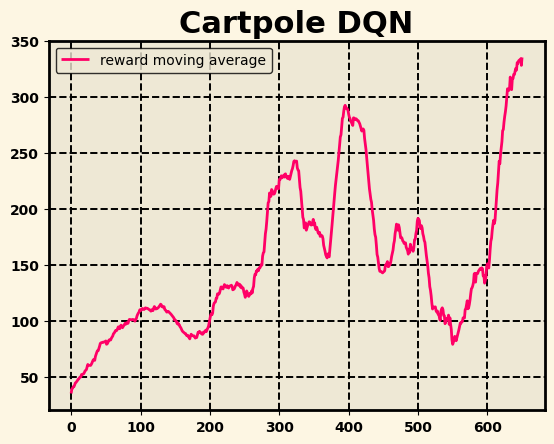

In [38]:

def moving_average(data:list,interval):
    move_average=[]
    for i in range(interval,len(data)):
        move_average.append(np.mean(data[i-interval:i]))
    return move_average    
    
plt.style.use('Solarize_Light2')
plt.plot(moving_average(rewards,50),label="reward moving average",color="#ff0066")
plt.title("Cartpole DQN",color="black",fontsize=22,weight='bold')
plt.tick_params(axis='both', colors='black')
plt.grid(ls="--",lw=1.4,color="black")
plt.legend(frameon=True, edgecolor='black') 
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_color('black')
    spine.set_linewidth(2)

# os.mkdir(f"./{PROJECT_NAME}")
# Save high-quality PNG
plt.savefig(f"../Result/{PROJECT_NAME}/{ENV_NAME}/Plots/plot_high_quality.png", dpi=300, bbox_inches='tight')

# Save high-quality SVG
plt.savefig(f"../Result/{PROJECT_NAME}/{ENV_NAME}/Plots/plot_high_quality.svg", format='svg', bbox_inches='tight')   

<center><b>Final Exploit


In [ ]:
env = gym.make(ENV_NAME, render_mode="human")
obs, _ = env.reset()
rew  = 0
done = False
while not done:

    obs = torch.tensor(obs).reshape(1, -1).float().to((device))
    with torch.no_grad():
        action_values = model(obs)
    action = torch.argmax(action_values).item()
    new_observation, reward, terminated, truncated, _ = env.step(action)
    obs   = new_observation
    rew  += reward
    done  = truncated or terminated
print(rew)
env.close()

500.0
